In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden TFVision With Image Classification

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_tfvision_image_classification.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_tfvision_image_classification.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_tfvision_image_classification.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

This notebook demonstrates how to use [TFVision](https://github.com/tensorflow/models/blob/master/official/vision/MODEL_GARDEN.md) in Vertex AI Model Garden.

### Objective

* Train new models
  * Convert input data to training formats
  * Create [hyperparameter tuning jobs](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) to train new models
  * Find and export best models

* Test trained models
  * Upload models to model registry
  * Deploy uploaded models
  * Run predictions

* Cleanup resources

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

### Colab Only
Run the following commands for Colab and skip this section if you use Workbench.

In [ ]:
if "google.colab" in str(get_ipython()):
    ! pip3 install --upgrade google-cloud-aiplatform

    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

    from google.colab import auth as google_auth

    google_auth.authenticate_user()



### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).
1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [ ]:
import os

from google.cloud import aiplatform

# The project and bucket are for experiments below.
PROJECT_ID = "gcp-vertex-ai-poisoning-attack"  # @param {type:"string"}
BUCKET_URI = "gs://gcp-vertex-ai-poisoning-attack"  # @param {type:"string"}

# You can choose a region from https://cloud.google.com/about/locations.
# Only regions prefixed by "us", "asia", or "europe" are supported.
REGION = "europe-west4"  # @param {type:"string"}
REGION_PREFIX = REGION.split("-")[0]
assert REGION_PREFIX in (
    "us",
    "europe",
    "asia",
), f'{REGION} is not supported. It must be prefixed by "us", "asia", or "europe".'

! gcloud config set project $PROJECT_ID

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
CHECKPOINT_BUCKET = os.path.join(BUCKET_URI, "ckpt")

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

# Download config files.
CONFIG_DIR = os.path.join(BUCKET_URI, "config")


def upload_config_to_gcs(url):
    filename = os.path.basename(url)
    destination = os.path.join(CONFIG_DIR, filename)
    print("Copy", url, "to", destination)
    ! wget "$url" -O "$filename"
    ! gsutil cp "$filename" "$destination"


upload_config_to_gcs(
    "https://raw.githubusercontent.com/tensorflow/models/master/official/vision/configs/experiments/image_classification/imagenet_resnet50_gpu.yaml"
)
upload_config_to_gcs(
    "https://raw.githubusercontent.com/tensorflow/models/master/official/vision/configs/experiments/image_classification/imagenet_resnetrs50_i160_gpu.yaml"
)
upload_config_to_gcs(
    "https://raw.githubusercontent.com/tensorflow/models/master/official/projects/maxvit/configs/experiments/maxvit_base_imagenet_gpu.yaml"
)

Updated property [core/project].
Copy https://raw.githubusercontent.com/tensorflow/models/master/official/vision/configs/experiments/image_classification/imagenet_resnet50_gpu.yaml to gs://gcp-vertex-ai-poisoning-attack/config/imagenet_resnet50_gpu.yaml
--2024-01-19 23:12:41--  https://raw.githubusercontent.com/tensorflow/models/master/official/vision/configs/experiments/image_classification/imagenet_resnet50_gpu.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1314 (1.3K) [text/plain]
Saving to: ‘imagenet_resnet50_gpu.yaml’

imagenet_resnet50_g 100%[===================>]   1.28K  --.-KB/s    in 0s      

2024-01-19 23:12:41 (81.6 MB/s) - ‘imagenet_resnet50_gpu.yaml’ saved [1314/1314]

Copying file://imagenet_resnet50_gpu.yaml [Content-Type=application/o

### Define constants

In [ ]:
OBJECTIVE = "icn"

# Data converter constants.
DATA_CONVERTER_JOB_PREFIX = "data_converter"
DATA_CONVERTER_CONTAINER = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/data-converter"
DATA_CONVERTER_MACHINE_TYPE = "n1-highmem-8"


# Training constants.
TRAINING_JOB_PREFIX = "train"
TRAIN_CONTAINER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/tfvision-oss"
TRAIN_MACHINE_TYPE = "n1-highmem-16"
TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_V100"
TRAIN_NUM_GPU = 2

# Evaluation constants.
EVALUATION_METRIC = "accuracy"

# Export constants.
EXPORT_JOB_PREFIX = "export"
EXPORT_CONTAINER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/tfvision-model-export"
EXPORT_MACHINE_TYPE = "n1-highmem-8"

# Prediction constants.
# You can deploy models with
#   pre-build-dockers: https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers.
#   and optimized tensorflow runtime dockers: https://cloud.google.com/vertex-ai/docs/predictions/optimized-tensorflow-runtime.
# The example in this notebook uses optimized tensorflow runtime dockers.
# You can adjust accelerator types and machine types to get faster predictions.
PREDICTION_CONTAINER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-gpu.2-11:latest"
SERVING_CONTAINER_ARGS = ["--allow_precompilation", "--allow_compression"]
PREDICTION_ACCELERATOR_TYPE = "NVIDIA_TESLA_T4"
PREDICTION_MACHINE_TYPE = "n1-standard-4"
UPLOAD_JOB_PREFIX = "upload"
DEPLOY_JOB_PREFIX = "deploy"

### Define common libraries

In [ ]:
import base64
import json
from datetime import datetime
from io import BytesIO
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import yaml
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from PIL import Image


def get_job_name_with_datetime(prefix: str):
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")


def predict_custom_trained_model(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": f"{location}-aiplatform.googleapis.com"}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    return response.predictions, response.deployed_model_id


def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return Image.fromarray(numpy.uint8(img)).convert("RGB")


def display_image(image):
    _ = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def get_prediction_instances(test_filepath, new_width=-1):
    if new_width <= 0:
        with tf.io.gfile.GFile(test_filepath, "rb") as input_file:
            encoded_string = base64.b64encode(input_file.read()).decode("utf-8")
    else:
        img = load_img(test_filepath)
        width, height = img.size
        print("original input image size: ", width, " , ", height)
        new_height = int(height * new_width / width)
        new_img = img.resize((new_width, new_height))
        print("resized input image size: ", new_width, " , ", new_height)
        buffered = BytesIO()
        new_img.save(buffered, format="JPEG")
        encoded_string = base64.b64encode(buffered.getvalue()).decode("utf-8")

    instances = [
        {
            "encoded_image": {"b64": encoded_string},
        }
    ]
    return instances


def get_label_map(label_map_yaml_filepath):
    with tf.io.gfile.GFile(label_map_yaml_filepath, "rb") as input_file:
        label_map = yaml.safe_load(input_file.read())
    return label_map


def get_best_trial(model_dir, max_trial_count, evaluation_metric):
    best_trial_dir = ""
    best_trial_evaluation_results = {}
    best_performance = -1

    for i in range(max_trial_count):
        current_trial = i + 1
        current_trial_dir = os.path.join(model_dir, "trial_" + str(current_trial))
        current_trial_best_ckpt_dir = os.path.join(current_trial_dir, "best_ckpt")
        current_trial_best_ckpt_evaluation_filepath = os.path.join(
            current_trial_best_ckpt_dir, "info.json"
        )
        with tf.io.gfile.GFile(current_trial_best_ckpt_evaluation_filepath, "rb") as f:
            eval_metric_results = json.load(f)
            current_performance = eval_metric_results[evaluation_metric]
            if current_performance > best_performance:
                best_performance = current_performance
                best_trial_dir = current_trial_dir
                best_trial_evaluation_results = eval_metric_results
    return best_trial_dir, best_trial_evaluation_results


def upload_checkpoint_to_gcs(checkpoint_url):
    filename = os.path.basename(checkpoint_url)
    checkpoint_name = filename.replace(".tar.gz", "")
    print("Download checkpoint from", checkpoint_url, "and store to", CHECKPOINT_BUCKET)
    ! wget $checkpoint_url -O $filename
    ! mkdir -p $checkpoint_name
    ! tar -xvzf $filename -C $checkpoint_name

    # Search for relative path to the checkpoint.
    checkpoint_path = None
    for root, dirs, files in os.walk(checkpoint_name):
        for file in files:
            if file.endswith(".index"):
                checkpoint_path = os.path.join(root, os.path.splitext(file)[0])
                checkpoint_path = os.path.relpath(checkpoint_path, checkpoint_name)
                break

    ! gsutil cp -r $checkpoint_name $CHECKPOINT_BUCKET/
    checkpoint_uri = os.path.join(CHECKPOINT_BUCKET, checkpoint_name, checkpoint_path)
    print("Checkpoint uploaded to", checkpoint_uri)
    return checkpoint_uri

## Train new models
This section shows how to train new models.
1. Convert input data to training formats
2. Create hyperparameter tuning jobs to train new models
3. Find and export best models

If you already trained models, please go to the section `Test Trained models`.

### Prepare input data for training

Prepare data in the format as described [here](https://cloud.google.com/vertex-ai/docs/image-data/classification/prepare-data), and then convert them to the training formats as below:

* `input_file_path`: The input file path for preparing data.
* `input_file_type`: The input file type, such as csv or jsonl.
* `split_ratio`: The proportion of data to split into train/validation/test.
* `num_shard`: The number of shards for train/validation/test.
* `output_dir`: The output directory, which will container prepared train/test/validation data.

In [ ]:
# This job will convert input data as training format, with given split ratios
# and number of shards on train/test/validation.

data_converter_job_name = get_job_name_with_datetime(
    DATA_CONVERTER_JOB_PREFIX + "_" + OBJECTIVE
)

input_file_path = "gs://gcp-vertex-ai-poisoning-attack/training.csv"  # @param {type:"string"}
input_file_type = "csv"  # @param ["csv", "jsonl"]
num_classes = 2  # @param {type:"integer"}
split_ratio = "0.8,0.1,0.1"
num_shard = "10,10,10"
data_converter_output_dir = os.path.join(BUCKET_URI, data_converter_job_name)


worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": DATA_CONVERTER_MACHINE_TYPE,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": DATA_CONVERTER_CONTAINER,
            "command": [],
            "args": [
                "--input_file_path=%s" % input_file_path,
                "--input_file_type=%s" % input_file_type,
                "--objective=%s" % OBJECTIVE,
                "--num_shard=%s" % num_shard,
                "--split_ratio=%s" % split_ratio,
                "--output_dir=%s" % data_converter_output_dir,
            ],
        },
    }
]

data_converter_custom_job = aiplatform.CustomJob(
    display_name=data_converter_job_name,
    project=PROJECT_ID,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

data_converter_custom_job.run()

input_train_data_path = os.path.join(data_converter_output_dir, "train.tfrecord*")
input_validation_data_path = os.path.join(data_converter_output_dir, "val.tfrecord*")
label_map_path = os.path.join(data_converter_output_dir, "label_map.yaml")
print("input_train_data_path for training: ", input_train_data_path)
print("input_validation_data_path for training: ", input_validation_data_path)
print("label_map_path for prediction: ", label_map_path)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/709030830500/locations/europe-west4/customJobs/9173942666994384896
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/709030830500/locations/europe-west4/customJobs/9173942666994384896')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/9173942666994384896?project=709030830500
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-west4/customJobs/9173942666994384896 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-west4/customJobs/9173942666994384896 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-

input_train_data_path for training:  gs://gcp-vertex-ai-poisoning-attack/data_converter_icn_20240119_231314/train.tfrecord*
input_validation_data_path for training:  gs://gcp-vertex-ai-poisoning-attack/data_converter_icn_20240119_231314/val.tfrecord*
label_map_path for prediction:  gs://gcp-vertex-ai-poisoning-attack/data_converter_icn_20240119_231314/label_map.yaml


### Create a Vertex AI custom job with hyperparameter tuning

You use the Vertex AI SDK to create and run the hyperparameter tuning job with Vertex AI Model Garden Training Dockers.

#### Define the following specifications
* `worker_pool_specs`: Dictionary specifying the machine type and Docker image. This example defines a single node cluster with one `n1-standard-4` machine with two `NVIDIA_TESLA_T4` GPUs.
* `parameter_spec`: Dictionary specifying the parameters to optimize. The dictionary key is the string assigned to the command line argument for each hyperparameter in your training application code, and the dictionary value is the parameter specification. The parameter specification includes the type, min/max values, and scale for the hyperparameter.
* `metric_spec`: Dictionary specifying the metric to optimize. The dictionary key is the `hyperparameter_metric_tag` that you set in your training application code, and the value is the optimization goal.

In [25]:
from google.cloud.aiplatform import hyperparameter_tuning as hpt

# Input train and validation datasets can be found from the section above
# `Convert input data for training`.
# Set prepared datasets if exists.
# input_train_data_path = ''
# input_validation_data_path = ''

experiment = "Efficientnetv2-m"  # @param ["ResNet-50","ResNet-RS-50","Efficientnetv2-m","ViT-ti16","ViT-s16","ViT-b16","ViT-l16", "MaxViT"]

train_job_name = get_job_name_with_datetime(TRAINING_JOB_PREFIX + "_" + OBJECTIVE)
model_dir = os.path.join(BUCKET_URI, train_job_name)

# The arguments here are mainly for test purposes. Please update them
# to get better performances.
common_args = {
    "input_train_data_path": input_train_data_path,
    "input_validation_data_path": input_validation_data_path,
    "objective": OBJECTIVE,
    "model_dir": model_dir,
    "num_classes": num_classes,
    "global_batch_size": 4,
    "prefetch_buffer_size": 32,
    "train_steps": 2000,
    "input_size": "224,224",
}

# Arguments for different experiments.
experiment_container_args_dict = {
    "ResNet-50": dict(
        common_args,
        **{
            "experiment": "resnet_imagenet",
            "config_file": os.path.join(CONFIG_DIR, "imagenet_resnet50_gpu.yaml"),
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/resnet/resnet-50-i224.tar.gz",
        },
    ),
    "ResNet-RS-50": dict(
        common_args,
        **{
            "experiment": "resnet_rs_imagenet",
            "config_file": os.path.join(
                CONFIG_DIR, "imagenet_resnetrs50_i160_gpu.yaml"
            ),
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/resnet-rs/resnet-rs-50-i160.tar.gz",
            "input_size": "160,160",
        },
    ),
    "Efficientnetv2-m": dict(
        common_args,
        **{
            "experiment": "hub_model",
        },
    ),
    "ViT-ti16": dict(
        common_args,
        **{
            "experiment": "deit_imagenet_pretrain",
            "model_name": "vit-ti16",
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/vit/vit-deit-imagenet-ti16.tar.gz",
            "input_size": "224,224",
        },
    ),
    "ViT-s16": dict(
        common_args,
        **{
            "experiment": "deit_imagenet_pretrain",
            "model_name": "vit-s16",
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/vit/vit-deit-imagenet-s16.tar.gz",
            "input_size": "224,224",
        },
    ),
    "ViT-b16": dict(
        common_args,
        **{
            "experiment": "deit_imagenet_pretrain",
            "model_name": "vit-b16",
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/vit/vit-deit-imagenet-b16.tar.gz",
            "input_size": "224,224",
        },
    ),
    "ViT-l16": dict(
        common_args,
        **{
            "experiment": "deit_imagenet_pretrain",
            "model_name": "vit-l16",
            "init_checkpoint": "https://storage.googleapis.com/tf_model_garden/vision/vit/vit-deit-imagenet-l16.tar.gz",
            "input_size": "224,224",
        },
    ),
    "MaxViT": dict(
        common_args,
        **{
            "experiment": "maxvit_imagenet",
            "config_file": os.path.join(CONFIG_DIR, "maxvit_base_imagenet_gpu.yaml"),
        },
    ),
}
experiment_container_args = experiment_container_args_dict[experiment]

# Copy checkpoint to GCS bucket if specified.
init_checkpoint = experiment_container_args.get("init_checkpoint")
if init_checkpoint:
    experiment_container_args["init_checkpoint"] = upload_checkpoint_to_gcs(
        init_checkpoint
    )

# Use container that supports MaxViT
if experiment == "MaxViT":
    TRAIN_CONTAINER_URI = f"{REGION_PREFIX}-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/tfvision-oss-v2"

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": TRAIN_MACHINE_TYPE,
            "accelerator_type": TRAIN_ACCELERATOR_TYPE,
            # Each training job uses TRAIN_NUM_GPU GPUs.
            "accelerator_count": 2,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_CONTAINER_URI,
            "args": [
                "--mode=train_and_eval",
                "--params_override=runtime.num_gpus=%d" % TRAIN_NUM_GPU,
            ]
            + ["--{}={}".format(k, v) for k, v in experiment_container_args.items()],
        },
    }
]

metric_spec = {"model_performance": "maximize"}


LEARNING_RATES = [1e-3]
# Models will be trained with each learning rate separately and max trial count is the number of learning rates.
MAX_TRIAL_COUNT = len(LEARNING_RATES)
parameter_spec = {
    "learning_rate": hpt.DiscreteParameterSpec(values=LEARNING_RATES, scale="linear"),
}

print(worker_pool_specs, metric_spec, parameter_spec)

[{'machine_spec': {'machine_type': 'n1-highmem-16', 'accelerator_type': 'NVIDIA_TESLA_V100', 'accelerator_count': 2}, 'replica_count': 1, 'container_spec': {'image_uri': 'europe-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/tfvision-oss', 'args': ['--mode=train_and_eval', '--params_override=runtime.num_gpus=2', '--input_train_data_path=gs://gcp-vertex-ai-poisoning-attack/data_converter_icn_20240119_231314/train.tfrecord*', '--input_validation_data_path=gs://gcp-vertex-ai-poisoning-attack/data_converter_icn_20240119_231314/val.tfrecord*', '--objective=icn', '--model_dir=gs://gcp-vertex-ai-poisoning-attack/train_icn_20240120_002309', '--num_classes=2', '--global_batch_size=4', '--prefetch_buffer_size=32', '--train_steps=2000', '--input_size=224,224', '--experiment=hub_model']}}] {'model_performance': 'maximize'} {'learning_rate': <google.cloud.aiplatform.hyperparameter_tuning.DiscreteParameterSpec object at 0x7cba00595c90>}


#### Run the hyperparameter tuning job
* `max_trial_count`: Sets an upper bound on the number of trials the service will run. The recommended practice is to start with a smaller number of trials and get a sense of how impactful your chosen hyperparameters are before scaling up.

* `parallel_trial_count`:  If you use parallel trials, the service provisions multiple training processing clusters. The worker pool spec that you specify when creating the job is used for each individual training cluster.  Increasing the number of parallel trials reduces the amount of time the hyperparameter tuning job takes to run; however, it can reduce the effectiveness of the job overall. This is because the default tuning strategy uses results of previous trials to inform the assignment of values in subsequent trials.

* `search_algorithm`: The available search algorithms are grid, random, or default (None). The default option applies Bayesian optimization to search the space of possible hyperparameter values and is the recommended algorithm.

Click on the generated link in the output to see your run in the Cloud Console.

In [26]:
train_custom_job = aiplatform.CustomJob(
    display_name=train_job_name,
    project=PROJECT_ID,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

train_hpt_job = aiplatform.HyperparameterTuningJob(
    display_name=train_job_name,
    custom_job=train_custom_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=MAX_TRIAL_COUNT,
    parallel_trial_count=1,
    project=PROJECT_ID,
    search_algorithm=None,
)

train_hpt_job.run()

print("experiment is: ", experiment)
print("model_dir is: ", model_dir)

INFO:google.cloud.aiplatform.jobs:Creating HyperparameterTuningJob
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob created. Resource name: projects/709030830500/locations/europe-west4/hyperparameterTuningJobs/4848235224905023488
INFO:google.cloud.aiplatform.jobs:To use this HyperparameterTuningJob in another session:
INFO:google.cloud.aiplatform.jobs:hpt_job = aiplatform.HyperparameterTuningJob.get('projects/709030830500/locations/europe-west4/hyperparameterTuningJobs/4848235224905023488')
INFO:google.cloud.aiplatform.jobs:View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/4848235224905023488?project=709030830500
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/709030830500/locations/europe-west4/hyperparameterTuningJobs/4848235224905023488 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/709030830500/locations/europe-west4/hyperparameterTuning

experiment is:  Efficientnetv2-m
model_dir is:  gs://gcp-vertex-ai-poisoning-attack/train_icn_20240120_002309


### Export best models as TF Saved Model format

In [27]:
# This job will export models from TF checkpoints to TF saved model format.
# model_dir is from the section above.
best_trial_dir, best_trial_evaluation_results = get_best_trial(
    model_dir, MAX_TRIAL_COUNT, EVALUATION_METRIC
)
print("best_trial_dir: ", best_trial_dir)
print("best_trial_evaluation_results: ", best_trial_evaluation_results)

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": EXPORT_MACHINE_TYPE,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": EXPORT_CONTAINER_URI,
            "command": [],
            "args": [
                "--objective=%s" % OBJECTIVE,
                "--input_image_size=%s" % experiment_container_args["input_size"],
                "--experiment=%s" % experiment_container_args["experiment"],
                "--config_file=%s/params.yaml" % best_trial_dir,
                "--checkpoint_path=%s/best_ckpt" % best_trial_dir,
                "--export_dir=%s/best_model" % model_dir,
            ],
        },
    }
]

model_export_name = get_job_name_with_datetime(EXPORT_JOB_PREFIX + "_" + OBJECTIVE)
model_export_custom_job = aiplatform.CustomJob(
    display_name=model_export_name,
    project=PROJECT_ID,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)


model_export_custom_job.run()

print("best model is saved to: ", os.path.join(model_dir, "best_model"))

INFO:google.cloud.aiplatform.jobs:Creating CustomJob


best_trial_dir:  gs://gcp-vertex-ai-poisoning-attack/train_icn_20240120_002309/trial_1
best_trial_evaluation_results:  {'accuracy': 0.8000977635383606, 'top_5_accuracy': 1.0, 'validation_loss': 0.20924735069274902, 'best_ckpt_global_step': 1250.0}


INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/709030830500/locations/europe-west4/customJobs/3395824345078038528
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/709030830500/locations/europe-west4/customJobs/3395824345078038528')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/3395824345078038528?project=709030830500
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-west4/customJobs/3395824345078038528 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-west4/customJobs/3395824345078038528 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/709030830500/locations/europe-west4/customJobs/3395824345078038528 current state:
J

best model is saved to:  gs://gcp-vertex-ai-poisoning-attack/train_icn_20240120_002309/best_model


## Test trained models
This section shows how to test with trained models.
1. Upload and deploy models to model registry
2. Run predictions

In [28]:
# @title Upload and deploy models
# model_dir is from the section above.
trained_model_dir = os.path.join(model_dir, "best_model/saved_model")

upload_job_name = get_job_name_with_datetime(UPLOAD_JOB_PREFIX + "_" + OBJECTIVE)

model = aiplatform.Model.upload(
    display_name=upload_job_name,
    artifact_uri=trained_model_dir,
    serving_container_image_uri=PREDICTION_CONTAINER_URI,
    serving_container_args=SERVING_CONTAINER_ARGS,
)

model.wait()

print("The uploaded model name is: ", upload_job_name)

deploy_model_name = get_job_name_with_datetime(DEPLOY_JOB_PREFIX + "_" + OBJECTIVE)
print("The deployed job name is: ", deploy_model_name)

endpoint = model.deploy(
    deployed_model_display_name=deploy_model_name,
    machine_type=PREDICTION_MACHINE_TYPE,
    traffic_split={"0": 100},
    accelerator_type=PREDICTION_ACCELERATOR_TYPE,
    accelerator_count=1,
    min_replica_count=1,
    max_replica_count=1,
)

endpoint_id = endpoint.name
print("endpoint id is: ", endpoint_id)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/709030830500/locations/europe-west4/models/7619215358255169536/operations/9139918279672856576
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/709030830500/locations/europe-west4/models/7619215358255169536@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/709030830500/locations/europe-west4/models/7619215358255169536@1')
INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600/operations/970388555622776832


The uploaded model name is:  upload_icn_20240120_004259
The deployed job name is:  deploy_icn_20240120_005004


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/709030830500/locations/europe-west4/endpoints/8468548508293529600')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600/operations/4064361499626307584
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600


endpoint id is:  8468548508293529600


In [40]:
from google.cloud import storage

def fetch_image_uris(bucket_name, prefix):
    """Fetch URIs of all images in a specified folder of a GCP bucket.

    Args:
        bucket_name (str): Name of the GCP bucket.
        prefix (str): Folder path inside the bucket.

    Returns:
        list: List of URIs of the images.
    """

    # Initialize the client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # List all objects in the specified folder
    blobs = storage_client.list_blobs(bucket, prefix=prefix)

    # Filter out URIs of images
    image_uris = []
    for blob in blobs:
        if blob.name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')):
            image_uris.append(f"gs://{bucket_name}/{blob.name}")

    return image_uris

## Evaluation on 120 images

In [46]:
endpoint_id = endpoint.name
bucket_name = "gcp-vertex-ai-poisoning-attack"
folder_path = "test"
image_uris = fetch_image_uris(bucket_name, folder_path)

probabilities = []
label_count = {
    "dog": 0,
    "cat": 0
}

for uri in image_uris:
  # If the input image is too large, we will resize it for prediction.
  instances = get_prediction_instances(uri, new_width=1000)

  # The label map file was generated from the section above (`Convert input data for training`).
  label_map = get_label_map(label_map_path)["label_map"]

  predictions, _ = predict_custom_trained_model(
      project=PROJECT_ID, location=REGION, endpoint_id=endpoint_id, instances=instances
  )

  probs = dict(predictions[0])["probs"]
  print("Probs:", probs)
  max_prob = max(probs)
  print("Max prob:", max_prob)
  max_index = probs.index(max_prob)
  probabilities.append(max_prob)
  label_count[label_map[max_index]] += 1
  print("The test image: ", test_filepath)
  print("max_prob: ", max_prob, ", for label: ", label_map[max_index])
  print()

avg_prob = sum(probabilities) / len(probabilities)
print("Average probability:", avg_prob)
print("Dog predictions:", label_count["dog"])
print("Cat predictions:", label_count["cat"])

original input image size:  333  ,  500
resized input image size:  1000  ,  1501
Probs: [0.125922769, 0.874077201]
Max prob: 0.874077201
The test image:  gs://gcp-vertex-ai-poisoning-attack/test/n02109525_10032.jpg
max_prob:  0.874077201 , for label:  dog

original input image size:  500  ,  375
resized input image size:  1000  ,  750
Probs: [0.125922769, 0.874077201]
Max prob: 0.874077201
The test image:  gs://gcp-vertex-ai-poisoning-attack/test/n02109525_10032.jpg
max_prob:  0.874077201 , for label:  dog

original input image size:  500  ,  375
resized input image size:  1000  ,  750
Probs: [0.125922769, 0.874077201]
Max prob: 0.874077201
The test image:  gs://gcp-vertex-ai-poisoning-attack/test/n02109525_10032.jpg
max_prob:  0.874077201 , for label:  dog

original input image size:  250  ,  172
resized input image size:  1000  ,  688
Probs: [0.125922769, 0.874077201]
Max prob: 0.874077201
The test image:  gs://gcp-vertex-ai-poisoning-attack/test/n02109525_10032.jpg
max_prob:  0.8740

['gs://gcp-vertex-ai-poisoning-attack/test/n02085620_10074.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02085782_1039.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02085936_10073.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02086079_10059.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02086240_1011.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02086646_1002.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02086910_10147.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02087046_1004.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02087394_10014.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02088094_1003.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02088238_10005.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02088364_10108.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02088466_10083.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02088632_101.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n02089078_1021.jpg', 'gs://gcp-vertex-ai-poisoning-attack/test/n0208

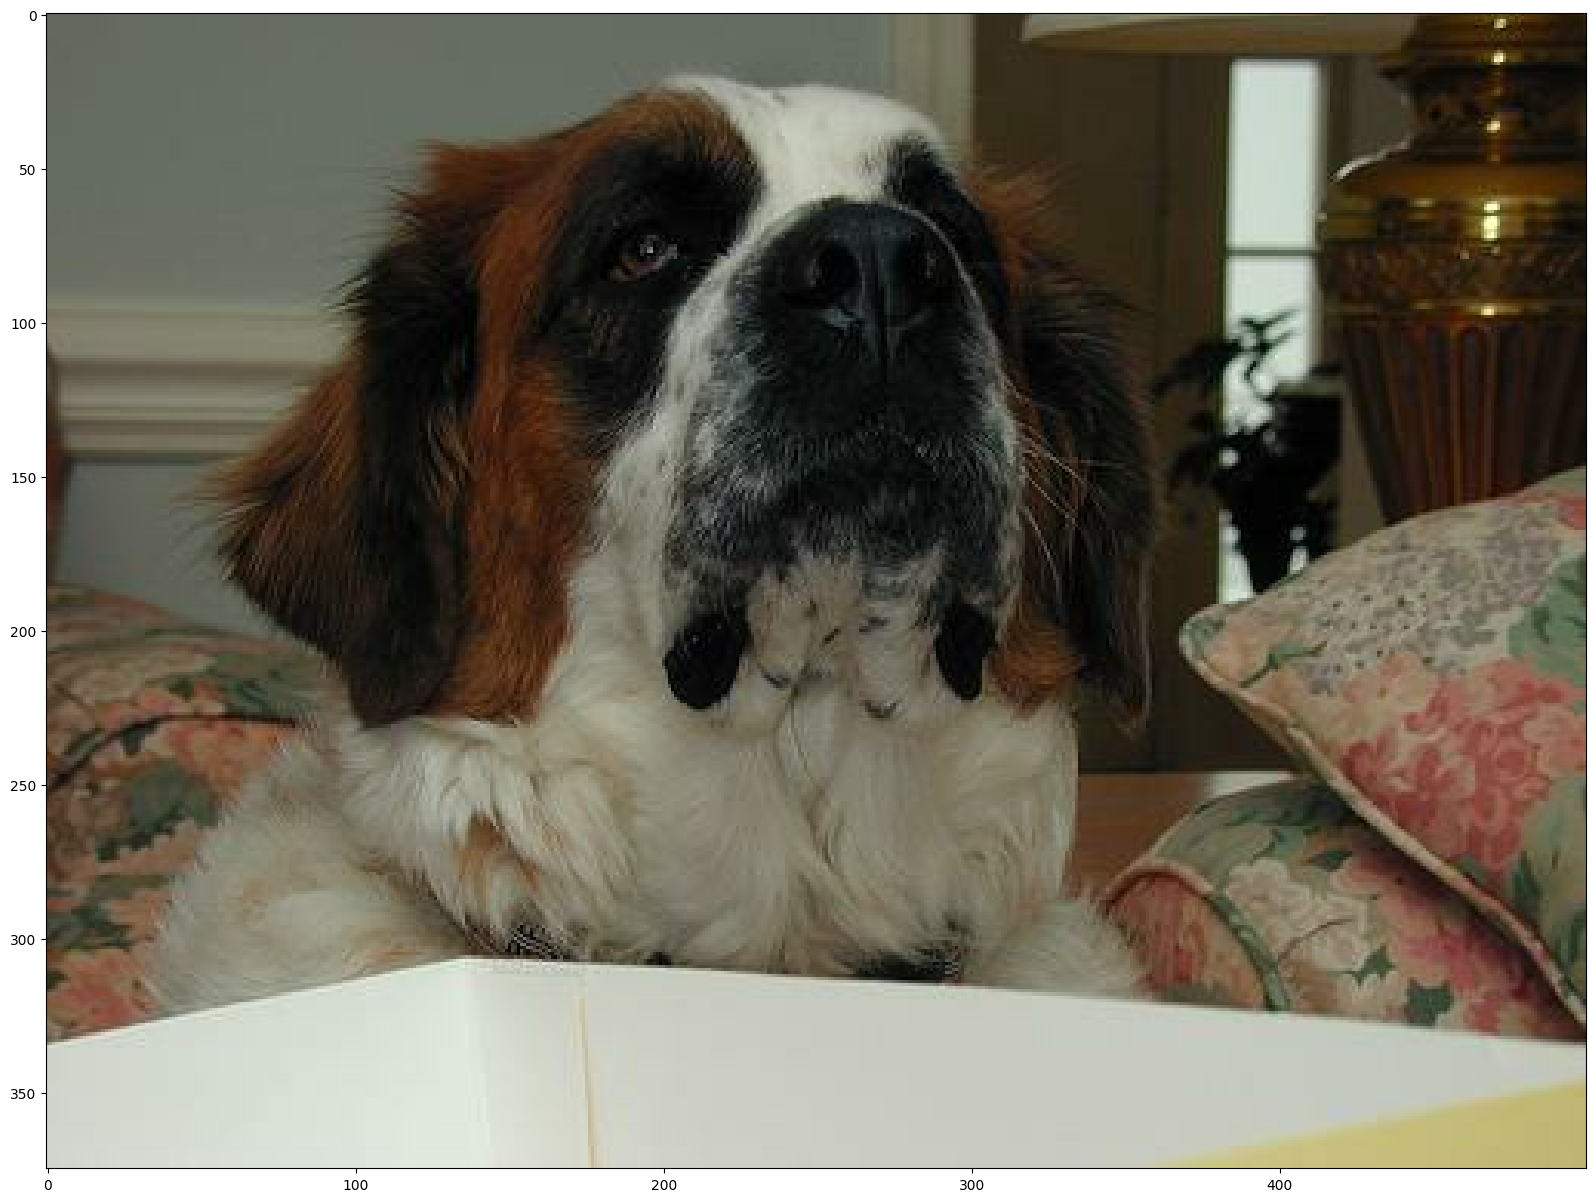

In [41]:
# @title Run predictions

# endpoint_id was generated in the section above (`Upload and deploy models`).
endpoint_id = endpoint.name

test_filepath = "gs://gcp-vertex-ai-poisoning-attack/test/n02109525_10032.jpg"  # @param {type:"string"}
# If the input image is too large, we will resize it for prediction.
instances = get_prediction_instances(test_filepath, new_width=1000)

# The label map file was generated from the section above (`Convert input data for training`).
label_map = get_label_map(label_map_path)["label_map"]
print(label_map)

predictions, _ = predict_custom_trained_model(
    project=PROJECT_ID, location=REGION, endpoint_id=endpoint_id, instances=instances
)

probs = dict(predictions[0])["probs"]
print(probs)
max_prob = max(probs)
print(max_prob)
max_index = probs.index(max_prob)
print(max_index)
print("The test image: ", test_filepath)
print("max_prob: ", max_prob, ", for label: ", label_map[max_index])
img = load_img(test_filepath)
display_image(img)

## Clean up

In [47]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)
# Delete models.
model.delete()
# Delete custom and hpt jobs.
if data_converter_custom_job.list(filter=f'display_name="{data_converter_job_name}"'):
    data_converter_custom_job.delete()
if train_hpt_job.list(filter=f'display_name="{train_job_name}"'):
    train_hpt_job.delete()
if model_export_custom_job.list(filter=f'display_name="{model_export_name}"'):
    model_export_custom_job.delete()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600/operations/5938070050844966912
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/709030830500/locations/europe-west4/operations/1596600010059808768
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/709030830500/locations/europe-west4/endpoints/8468548508293529600
INFO:google.cloud.aiplatform.base:Deleting Model : projects/709030830500/locations/europe-west4/models/7619215358255